## Access Vessel Air Sea Flux Sst Meteo Realtime (Parquet)

This Jupyter notebook demonstrates how to access and plot vessel air sea flux sst meteo realtime data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/9436802f-ed93-4660-be50-e77c3c07bd09).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/vessel_air_sea_flux_sst_meteo_realtime.ipynb).


In [1]:
dataset_name = "vessel_air_sea_flux_sst_meteo_realtime"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 59ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 533 ms, sys: 85.6 ms, total: 618 ms
Wall time: 9.64 s


In [5]:
aodn_dataset.dataset.partitioning.schema

platform_code: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('platform_code')
print(list(unique_partition_value)) 

['VMIC', 'VLMJ', 'VNAA', 'ZMFR', 'VLHJ']
CPU times: user 87.3 ms, sys: 3.06 ms, total: 90.4 ms
Wall time: 88.4 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


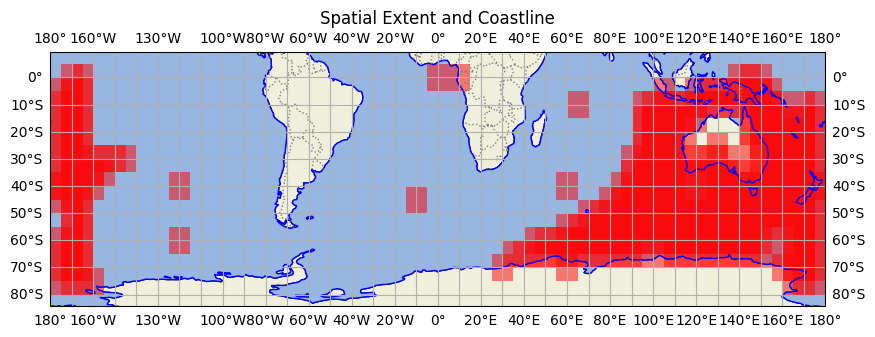

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2008-01-27 00:00:00'), Timestamp('2025-06-04 23:59:00.000003584'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:23:08,032 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/vessel_air_sea_flux_sst_meteo_realtime.parquet
2025-06-05 13:23:08,309 - aodn.GetAodn - ERROR - Error decoding JSON for key b'TEMP': Expecting ',' delimiter: line 1 column 356 (char 355)
2025-06-05 13:23:08,310 - aodn.GetAodn - ERROR - Problematic JSON string: {"type": "float", "long_name": "sea temperature", "units": "celsius", "instrument": "Seabird SBE 38 (s/n 1061)", "observation_type": "measured", "distance_from_bow": -33.06100082397461, "centerline_offset": 0.8999999761581421, "sensor_depth": 5.900000095367432, "comment": "The height attribute refers to the depth of the seawater intake below the vessel"s Summer Water Line when the port drop keel is flush with the ship"s hull. However, the actual depth of the seawater intake is height-KEEL_EXT. The KEEL_EXT can vary throughout a cruise. For KEEL_EXT=0 the SBE 38 sensor will not operate.", "standard_name": "sea_surface_temperature", "ancill

{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'platform_code': {'type': 'string'},
 'site': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comment': 'Relative julian days with decimal part as parts of the day',
  'ancillary_variables': 'TIME_quality_control'},
 'LATITUDE': {'type': 'float',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'instrument': 'Seapath 330+ position and reference unit',
  'observation_type': 'measured',
  'standard_name': 'latitude',
  'axis': 'Y',
  'valid_min': -90,
  'valid_max': 90,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LATITUDE_quality_control'},
 'LONGITUDE': {'type': 'float',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'instrument': 'Seapath 330+ position and reference unit',
  'observation_type': 'measured',
  'standard_

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2009-08-01', date_end='2010-11-01',lat_min=-60, lat_max=-28, lon_min=140, lon_max=160)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817175 entries, 0 to 2817174
Data columns (total 91 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   filename                       object        
 1   site                           object        
 2   TIME                           datetime64[ns]
 3   LATITUDE                       float32       
 4   LONGITUDE                      float32       
 5   PL_HD                          float32       
 6   PL_CRS                         float32       
 7   PL_SPD                         float32       
 8   PL_WDIR                        float32       
 9   PL_WSPD                        float32       
 10  WDIR                           float32       
 11  WSPD                           float32       
 12  PL_WDIR_2                      float32       
 13  PL_WSPD_2                      float32       
 14  WDIR_2                         float32       
 15  WSPD_2         

In [ ]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

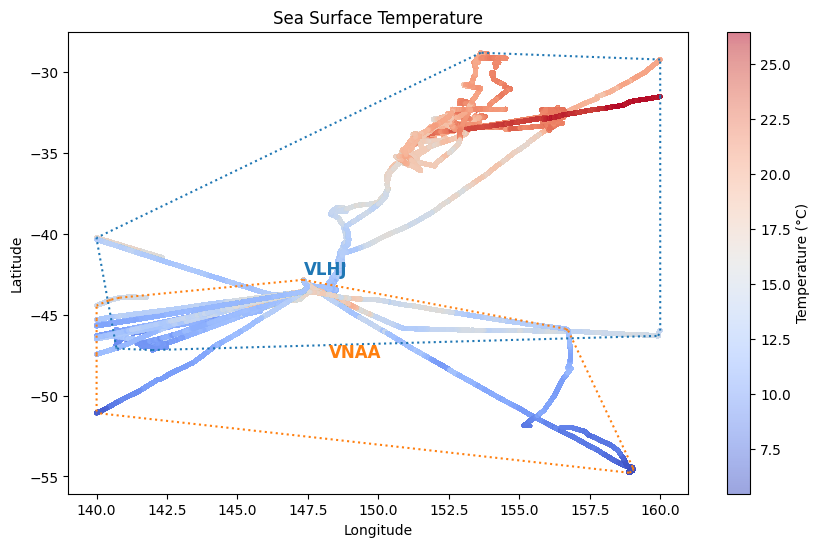

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from itertools import cycle

# function to plot the convex hull around the vessel's data points
def draw_convex_hull(ax, points, label, color):
    hull = ConvexHull(points)
    # Plot the convex hull as a dotted polygon
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], linestyle=':', color=color, linewidth=1.5)
    
    centroid = np.mean(points[hull.vertices], axis=0)
    ax.text(centroid[0], centroid[1], label, fontsize=12, weight='bold', ha='center', color=color)

plt.figure(figsize=(10, 6))

# Adjusting alpha to reduce darkness
sc = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['TEMP'], cmap='coolwarm', s=10, edgecolor='none', alpha=0.5)

cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)')

# Labels and titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature')

# assign different colors to each platform
color_cycle = cycle(plt.cm.tab10.colors)  # Use a colormap with 10 distinct colors

# Group the data by platform_code
unique_vessels = df['platform_code'].unique()

# Draw convex hulls for each unique vessel
for vessel in unique_vessels:
    df_vessel = df[df['platform_code'] == vessel]
    
    # Combine the longitude and latitude into a set of points
    points = df_vessel[['LONGITUDE', 'LATITUDE']].to_numpy()
    
    # Only draw convex hull if there are enough points
    if len(points) >= 3:
        color = next(color_cycle)  # Get the next color from the color cycle
        draw_convex_hull(plt.gca(), points, vessel, color)

plt.show()


## Create a TIME and scalar/number filter

In [12]:
%%time
df = aodn_dataset.get_data(date_start='2022-07-12', date_end='2023-02-05', scalar_filter={'platform_code': 'VLMJ'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4443520 entries, 0 to 4443519
Data columns (total 91 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   filename                       object        
 1   site                           object        
 2   TIME                           datetime64[ns]
 3   LATITUDE                       float32       
 4   LONGITUDE                      float32       
 5   PL_HD                          float32       
 6   PL_CRS                         float32       
 7   PL_SPD                         float32       
 8   PL_WDIR                        float32       
 9   PL_WSPD                        float32       
 10  WDIR                           float32       
 11  WSPD                           float32       
 12  PL_WDIR_2                      float32       
 13  PL_WSPD_2                      float32       
 14  WDIR_2                         float32       
 15  WSPD_2         

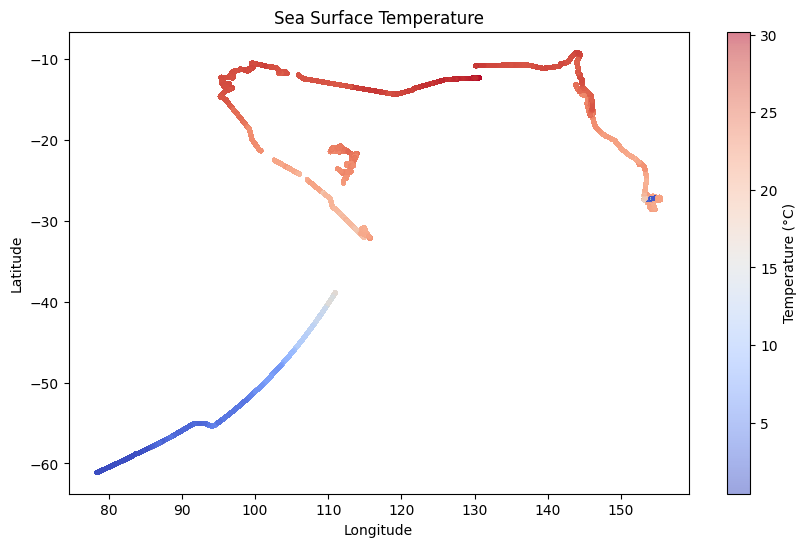

In [13]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(df['LONGITUDE'], df['LATITUDE'], c=df['TEMP'], cmap='coolwarm', s=10, edgecolor='none', alpha=0.5)

# Adding colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)')

# Labels and titles
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature')

plt.show()